# A New-Keynesian Model

Consider the new-Keynesian business cycle model from Walsh (2017), chapter 8 expressed in log-linear terms:

\begin{align}
y_t & = E_ty_{t+1} - \sigma^{-1} (i_t - E_t\pi_{t+1}) + g_t\\
\pi_t & = \beta  E_t\pi_{t+1} + \kappa  y_t + u_t\\
i_t & = \phi_x  y_t + \phi_{\pi}  \pi_t + v_t\\
r_t & = i_t - E_t\pi_{t+1}\\
g_{t+1} & = \rho_g g_{t} + \epsilon_{t+1}^g\\
u_{t+1} & = \rho_u u_{t} + \epsilon_{t+1}^u\\
v_{t+1} & = \rho_v v_{t} + \epsilon_{t+1}^v
\end{align}

where $y_t$ is the output gap (log-deviation of output from the natural rate), $\pi_t$ is the quarterly rate of inflation between $t-1$ and $t$, $i_t$ is the nominal interest rate on funds moving between period $t$ and $t+1$, $r_t$ is the real interest rate, $g_t$ is the exogenous component of demand, $u_t$ is an exogenous component of inflation, and $v_t$ is the exogenous component of monetary policy.

Since the model is already log-linear, there is no need to approximate the equilibrium conditions. We'll still use the `.log_linear` method to find the matrices $A$ and $B$, but we'll have to set the `islinear` option to `True` to avoid generating an error.

## Import requisite modules

In [1]:
# Import numpy, pandas, linearsolve, matplotlib.pyplot
import numpy as np
import pandas as pd
import linearsolve as ls
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

## Inintialize model and solve

In [2]:
# Input model parameters
beta = 0.99
sigma= 1
eta  = 1
omega= 0.8
kappa= (sigma+eta)*(1-omega)*(1-beta*omega)/omega

rhor = 0.9
phipi= 1.5
phiy = 0

rhog = 0.5
rhou = 0.5
rhov = 0.9

Sigma = 0.001*np.eye(3)

# Store parameters
parameters = pd.Series({
    'beta':beta,
    'sigma':sigma,
    'eta':eta,
    'omega':omega,
    'kappa':kappa,
    'rhor':rhor,
    'phipi':phipi,
    'phiy':phiy,
    'rhog':rhog,
    'rhou':rhou,
    'rhov':rhov
})


# Define function that computes equilibrium conditions
def equations(variables_forward,variables_current,parameters):
    
    # Parameters 
    p = parameters
    
    # Variables
    fwd = variables_forward
    cur = variables_current
    
    # Exogenous demand
    g_proc =  p.rhog*cur.g - fwd.g
    
    # Exogenous inflation
    u_proc =  p.rhou*cur.u - fwd.u
    
    # Exogenous monetary policy
    v_proc =  p.rhov*cur.v - fwd.v
    
    # Euler equation
    euler_eqn = fwd.y -1/p.sigma*(cur.i-fwd.pi) + fwd.g - cur.y
    
    # NK Phillips curve evolution
    phillips_curve = p.beta*fwd.pi + p.kappa*cur.y + fwd.u - cur.pi
    
    # interest rate rule
    interest_rule = p.phiy*cur.y+p.phipi*cur.pi + fwd.v - cur.i
    
    # Fisher equation
    fisher_eqn = cur.i - fwd.pi - cur.r
    
    
    # Stack equilibrium conditions into a numpy array
    return np.array([
            g_proc,
            u_proc,
            v_proc,
            euler_eqn,
            phillips_curve,
            interest_rule,
            fisher_eqn
        ])

# Initialize the nk model
nk = ls.model(equations=equations,
              n_states=3,
              n_exo_states = 3,
              var_names=['g','u','v','i','r','y','pi'],
              parameters=parameters)

# Set the steady state of the nk model
nk.set_ss([0,0,0,0,0,0,0])

# Find the log-linear approximation around the non-stochastic steady state
nk.linear_approximation()

# Solve the nk model
nk.solve_klein(nk.a,nk.b)

## Compute impulse responses and plot

Compute impulse responses of the endogenous variables to a one percent shock to each exogenous variable.

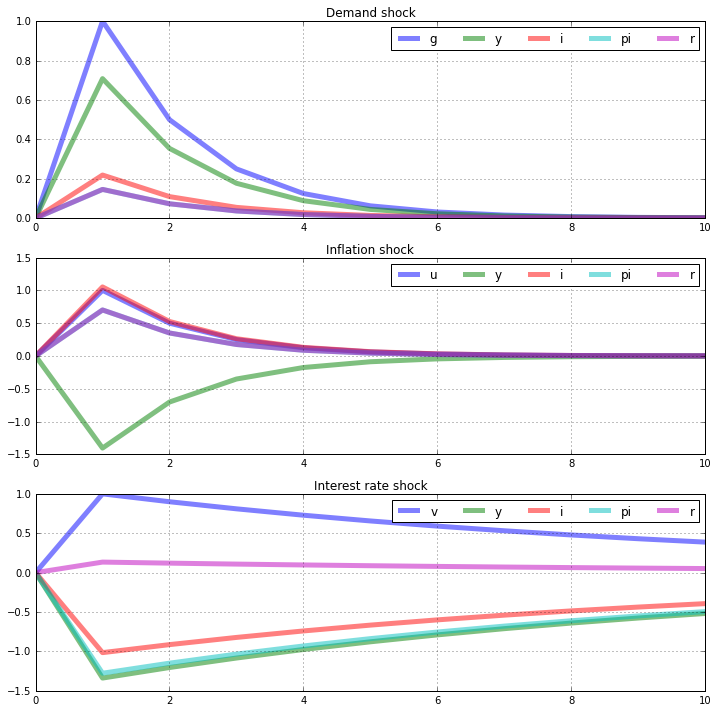

In [3]:
# Compute impulse responses
nk.impulse(T=11,t0=1,shocks=None)

# Create the figure and axes
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(3,1,1)
ax2 = fig.add_subplot(3,1,2)
ax3 = fig.add_subplot(3,1,3)

# Plot commands
nk.irs['e_g'][['g','y','i','pi','r']].plot(lw='5',alpha=0.5,grid=True,title='Demand shock',ax=ax1).legend(loc='upper right',ncol=5)
nk.irs['e_u'][['u','y','i','pi','r']].plot(lw='5',alpha=0.5,grid=True,title='Inflation shock',ax=ax2).legend(loc='upper right',ncol=5)
nk.irs['e_v'][['v','y','i','pi','r']].plot(lw='5',alpha=0.5,grid=True,title='Interest rate shock',ax=ax3).legend(loc='upper right',ncol=5)

## Construct a stochastic simulation and plot

Contruct a 151 period stochastic simulation by first siumlating the model for 251 periods and then dropping the first 100 values. The seed for the numpy random number generator is set to 0.

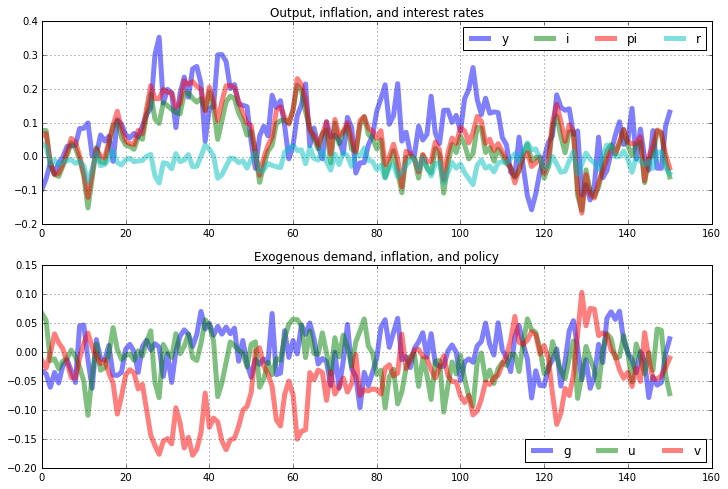

In [4]:
# Compute stochastic simulation
nk.stoch_sim(T=151,drop_first=100,cov_mat=Sigma,seed=0)

# Create the figure and axes
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

# Plot commands
nk.simulated[['y','i','pi','r']].plot(lw='5',alpha=0.5,grid=True,title='Output, inflation, and interest rates',ax=ax1).legend(ncol=4)
nk.simulated[['g','u','v']].plot(lw='5',alpha=0.5,grid=True,title='Exogenous demand, inflation, and policy',ax=ax2).legend(ncol=4,loc='lower right')

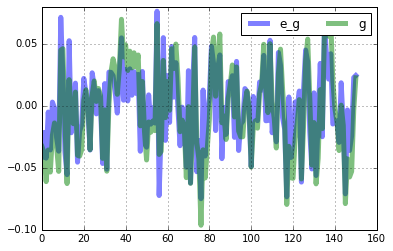

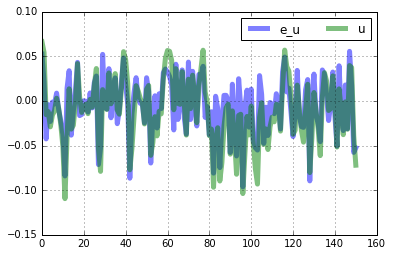

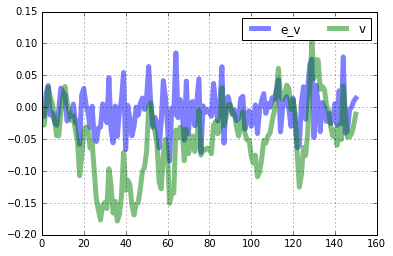

In [5]:
# Plot simulated exogenous shocks
nk.simulated[['e_g','g']].plot(lw='5',alpha=0.5,grid=True).legend(ncol=2)
nk.simulated[['e_u','u']].plot(lw='5',alpha=0.5,grid=True).legend(ncol=2)
nk.simulated[['e_v','v']].plot(lw='5',alpha=0.5,grid=True).legend(ncol=2)